https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html

<a id='home'></a>
### Contents

[Imports](#Imports)

[EDA and processing](#EDAandprocessing)

[Preraring dataloaders](#Preraringdataloaders)

[Baseline model](#Baselinemodel)

[Temporal Fusion Transformer](#TemporalFusionTransformer)

 - [Find optimal learning rate](#Findoptimallearningrate)
 
 - [Model training](#Modeltraining)
 
 - [Evaluate performance](#Evaluateperformance)

<a id='Imports'></a>
### Imports
[back to contents](#home)

In [1]:
import os
import sys
import copy
from pathlib import Path
import time
import itertools
from tqdm.notebook import tqdm
import pickle
import json
import joblib
import collections


import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sweetviz # 2.1.4

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [7]:
import pytorch_lightning as pl # version 1.6.5
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch # torch @ https://download.pytorch.org/whl/cu113/torch-1.12.0%2Bcu113-cp37-cp37m-linux_x86_64.whl

# version 0.10.1
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

---

<a id='EDAandprocessing'></a>
### EDA and processing
[back to contents](#home)

In [13]:
pd.set_option('display.max.columns', 100)
pd.set_option('display.max.rows', 100)

In [8]:
from pytorch_forecasting.data.examples import get_stallion_data
data = get_stallion_data()

In [17]:
print(f"data: {data.shape[0]:,} x {data.shape[1]:,}")
data.sample(n=5, random_state=42)

data: 21,000 x 26


,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries
15816,Agency_23,SKU_04,58.53240,2013-07-01,508376577,869768947,30.583529,1973.631989,1803.869933,169.762056,49101,90240,0,0,0,0,0,0,0,0,0,0,0,0,8.601505,329
1594,Agency_37,SKU_18,0.50850,2017-01-01,562154016,845614054,32.185603,1552.300885,1443.743363,108.557522,32769,96761,0,0,1,0,0,0,0,0,0,0,0,0,6.993330,6
14414,Agency_16,SKU_04,1092.75375,2014-06-01,553838801,865152191,24.674123,2041.644065,1876.368579,165.275486,1232242,246911,0,0,0,0,0,0,0,0,0,0,0,0,8.095215,56
11907,Agency_18,SKU_02,102.81600,2017-04-01,589969396,940912941,35.616900,1639.750000,1216.915704,422.834296,60189,135477,1,1,0,0,0,0,0,0,0,0,0,0,25.786510,143
20230,Agency_09,SKU_04,872.49075,2015-09-01,553979958,742568762,33.089655,2113.093419,1847.401461,265.691958,1646094,213511,0,0,0,0,0,1,0,0,0,0,0,0,12.573602,49


                                             |          | [  0%]   00:00 -> (? left)


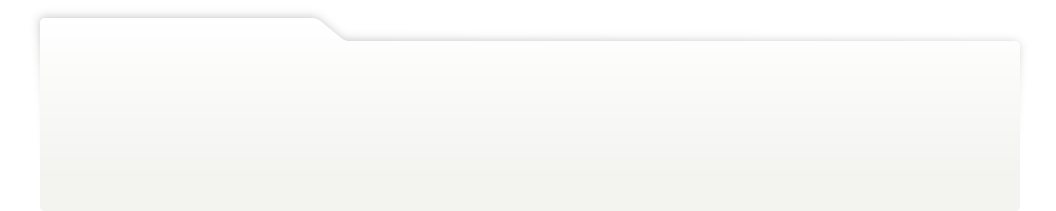
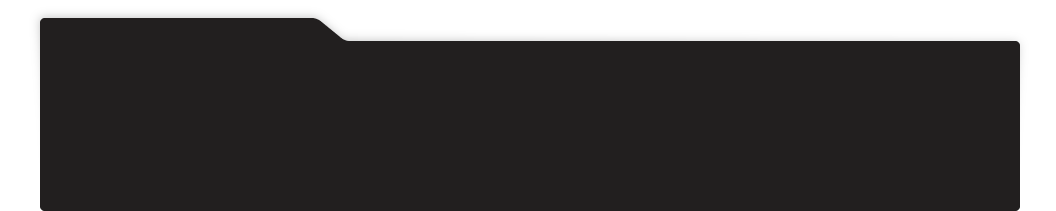
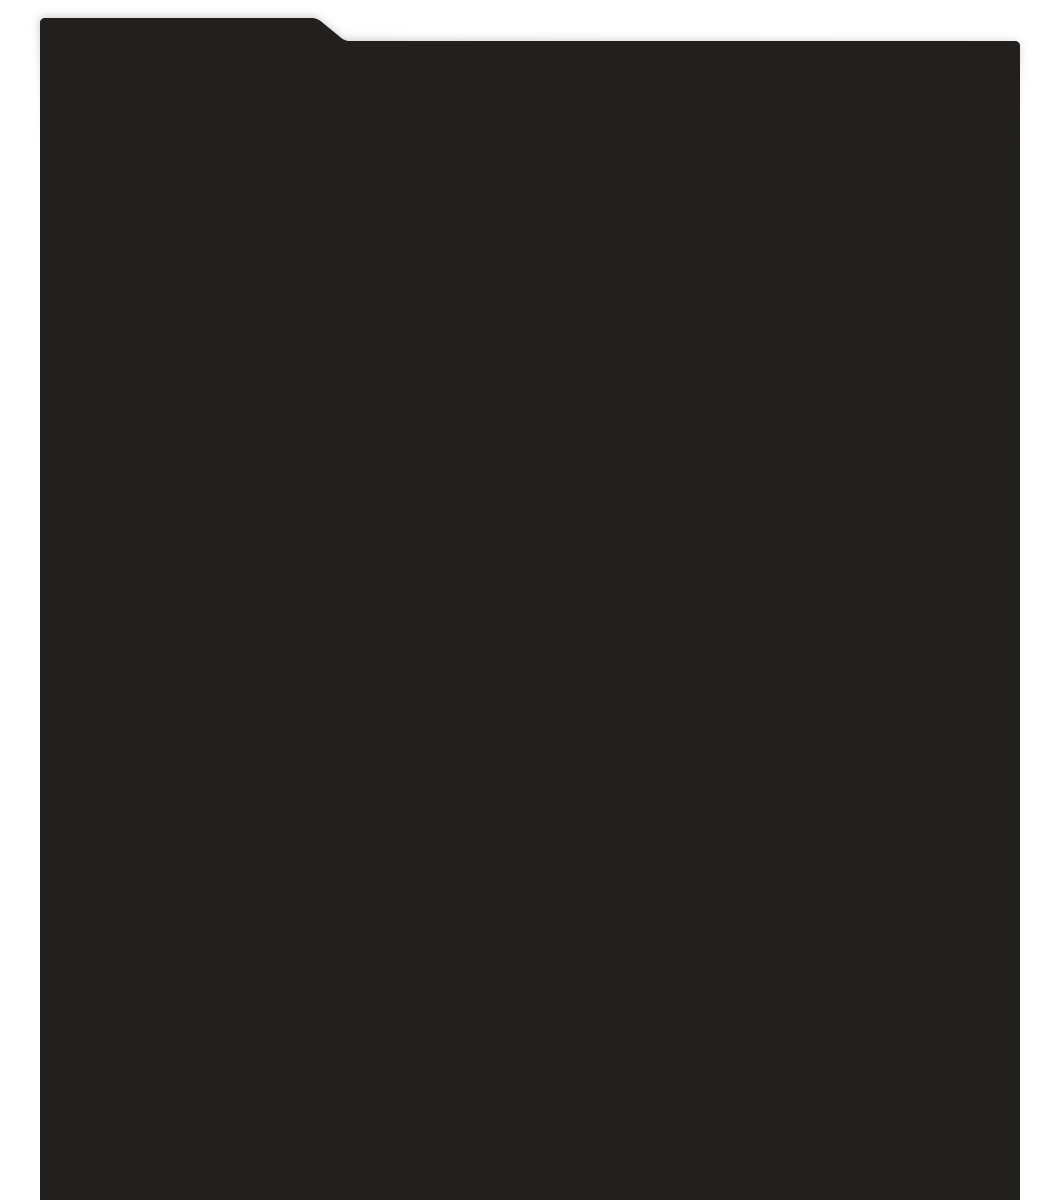
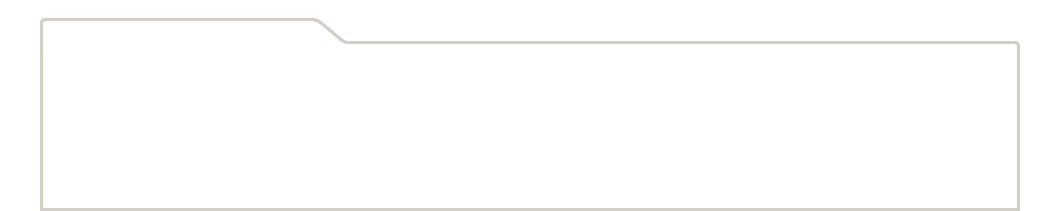
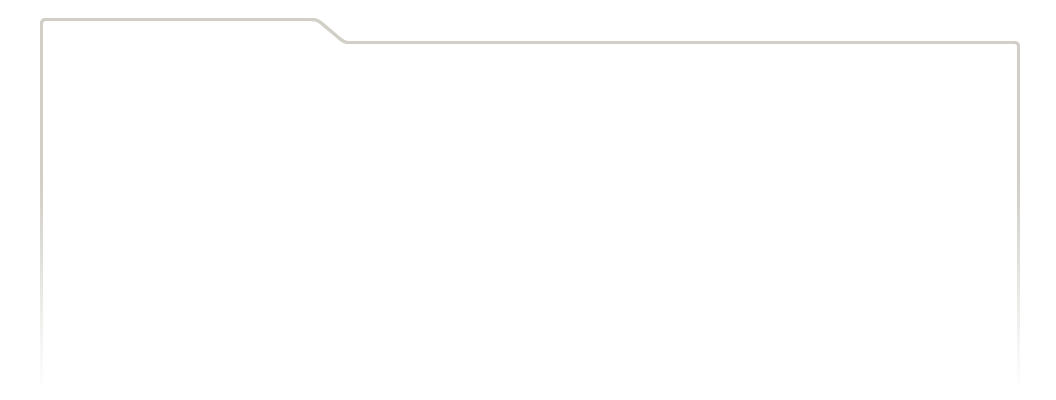
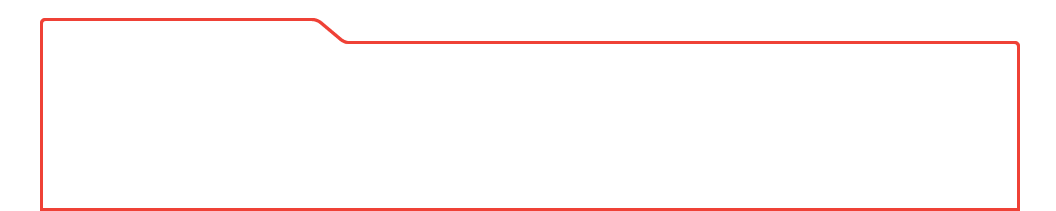
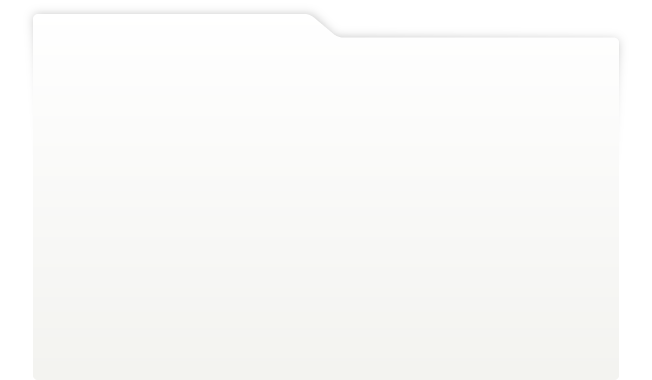
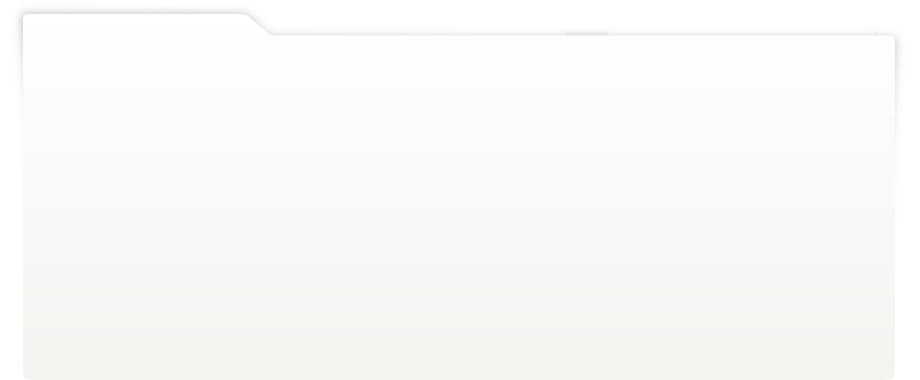
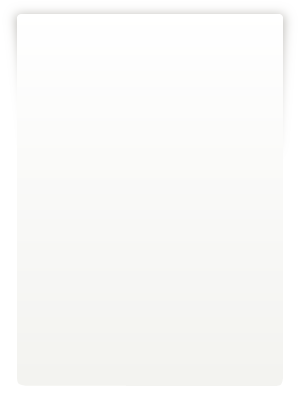
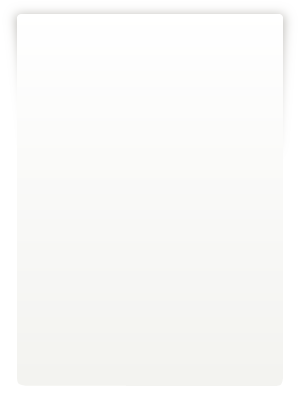
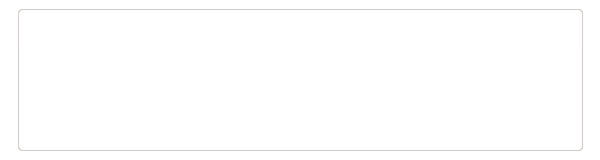
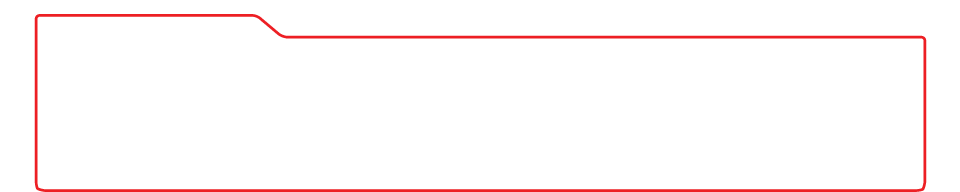
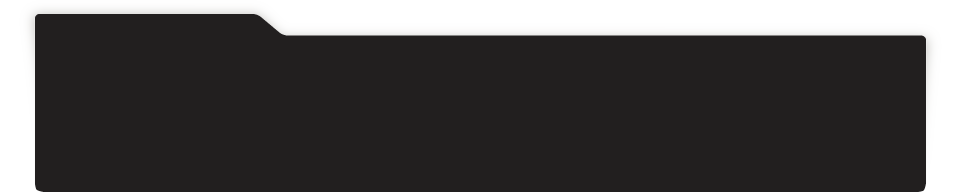
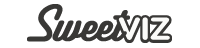
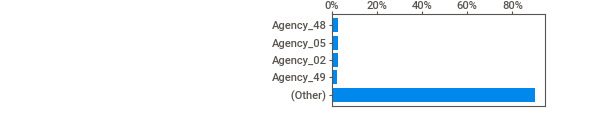
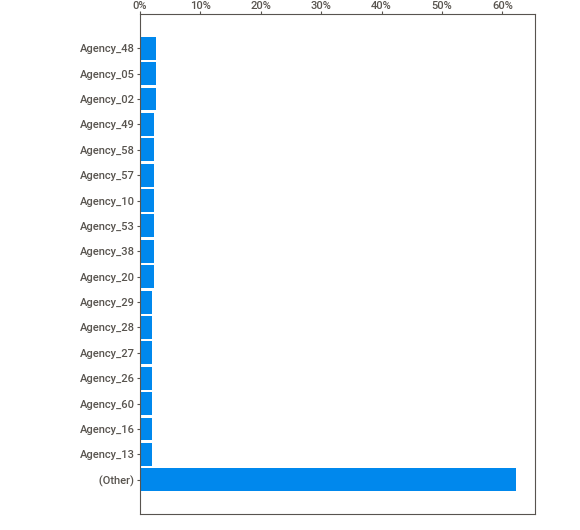
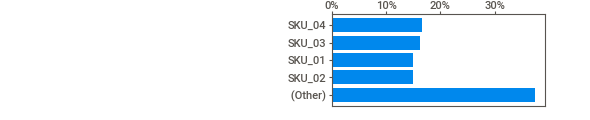
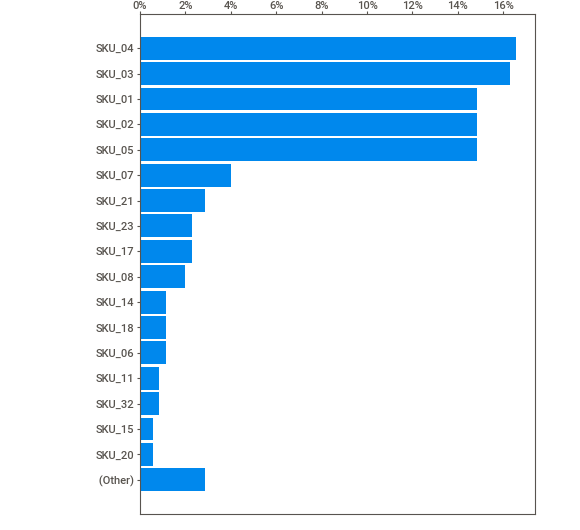
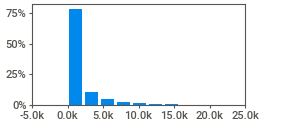
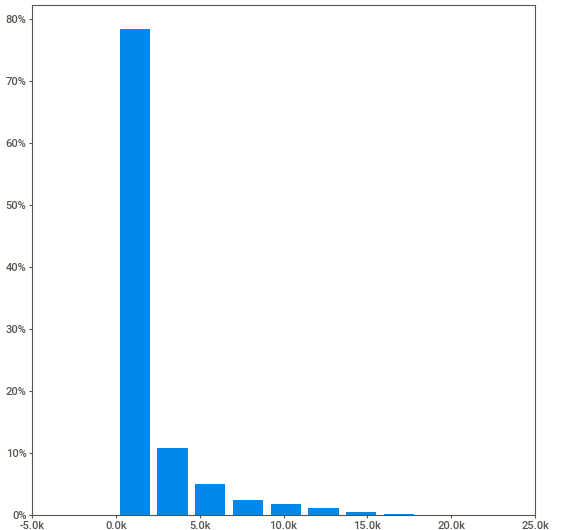
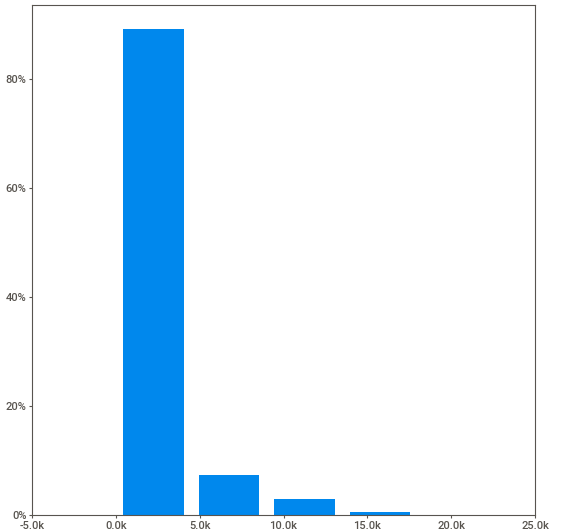
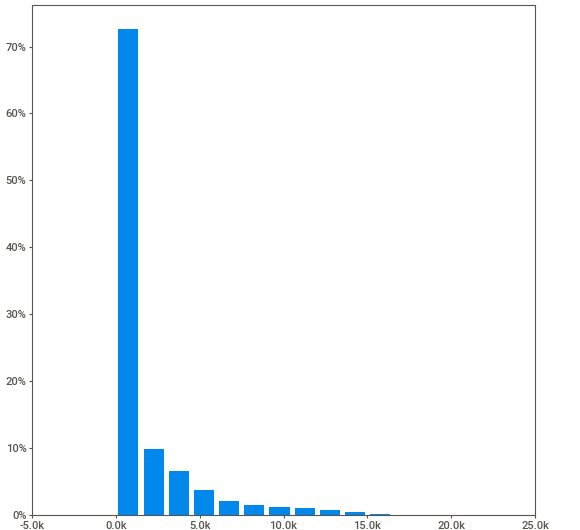
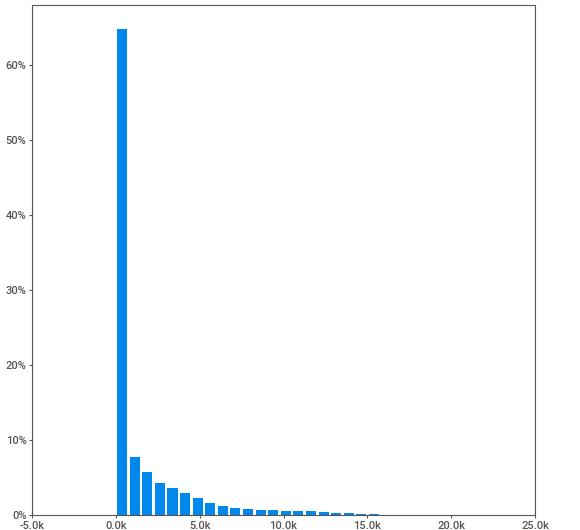
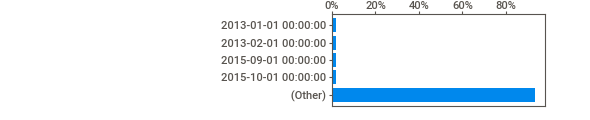
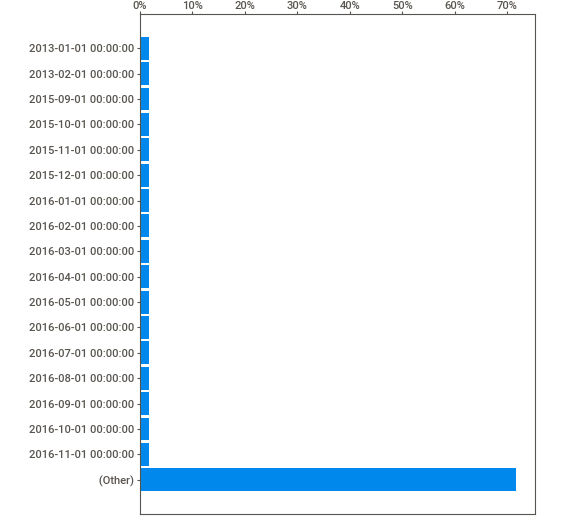
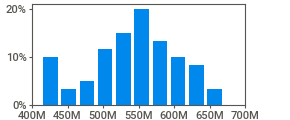
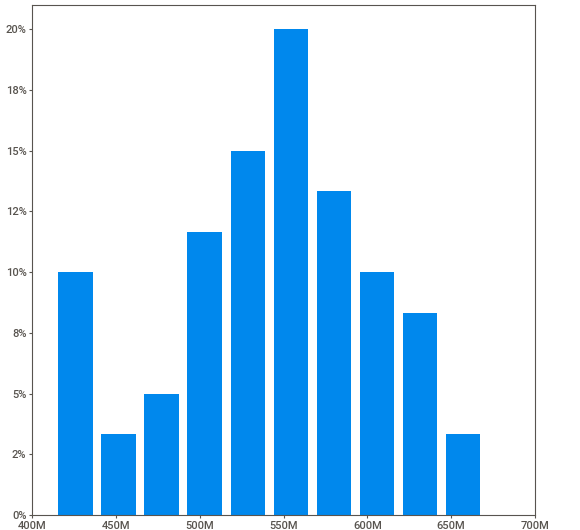
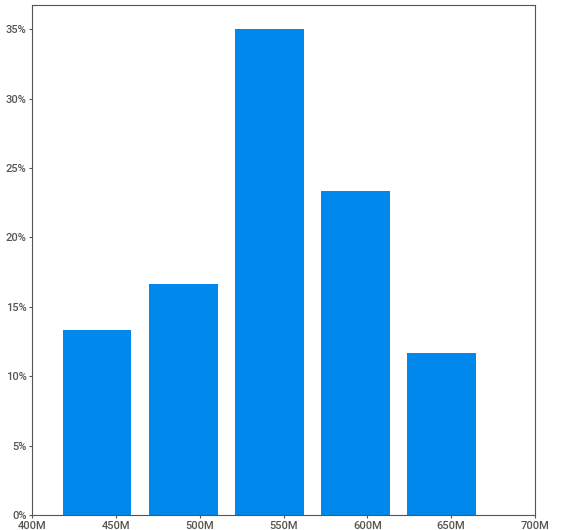
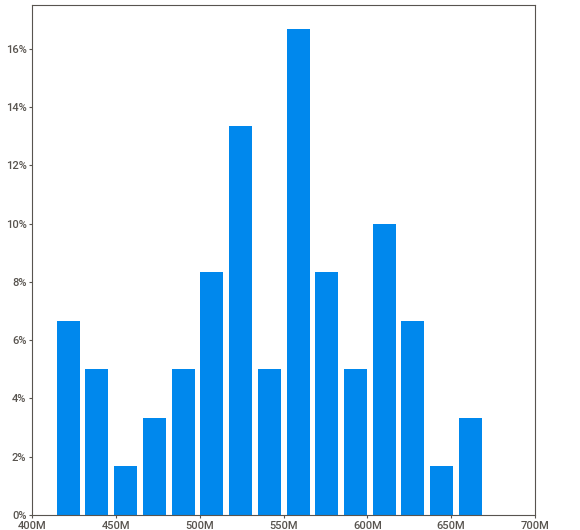
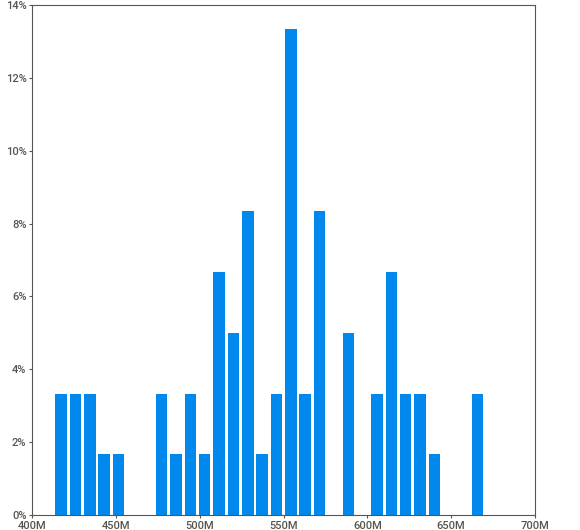
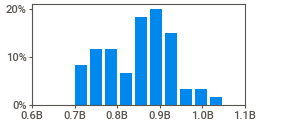
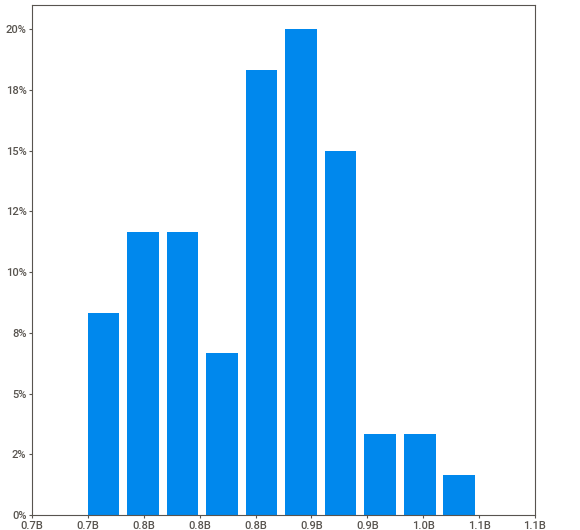
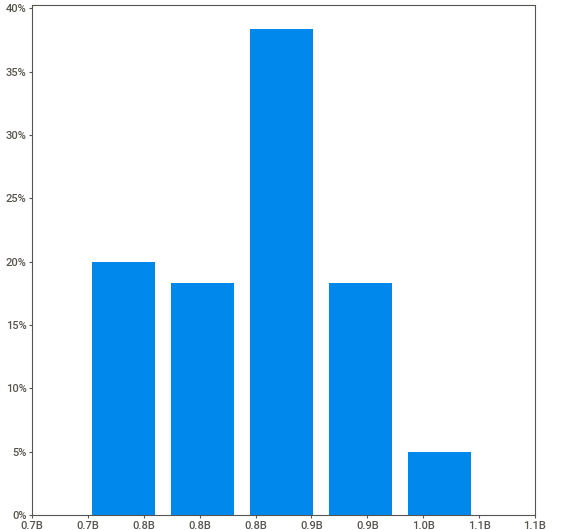
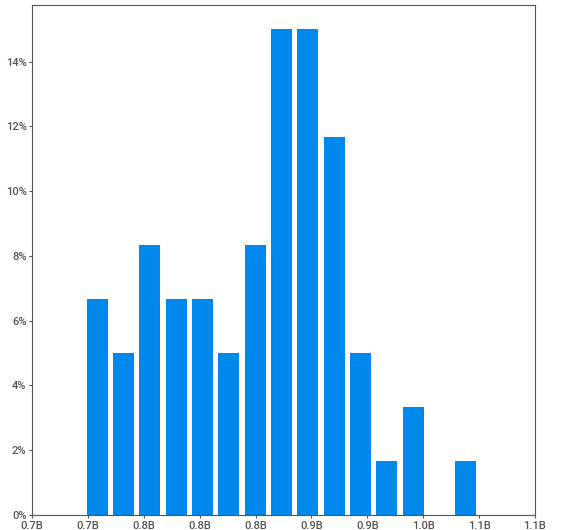
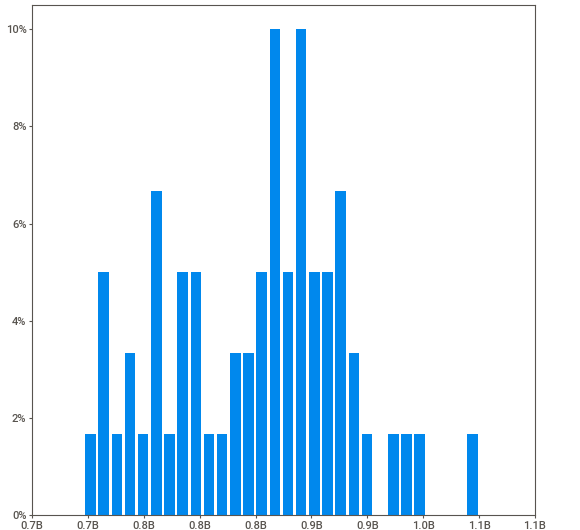
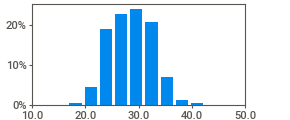
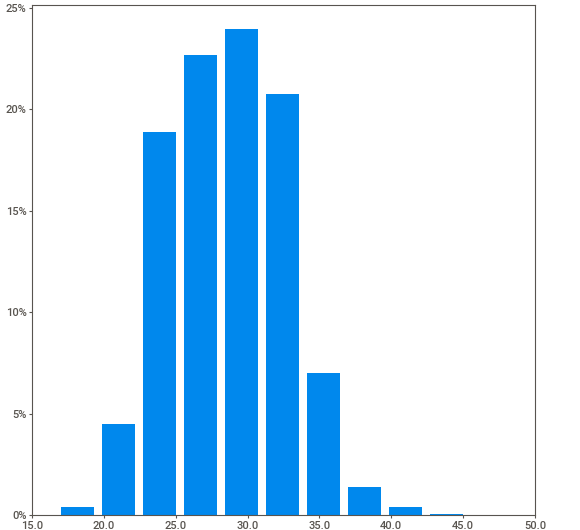
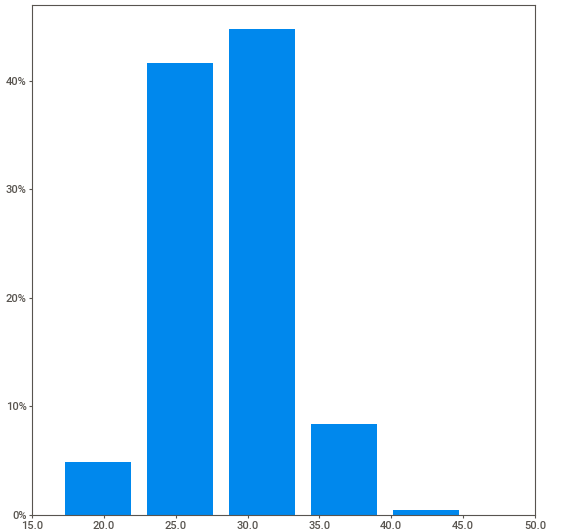
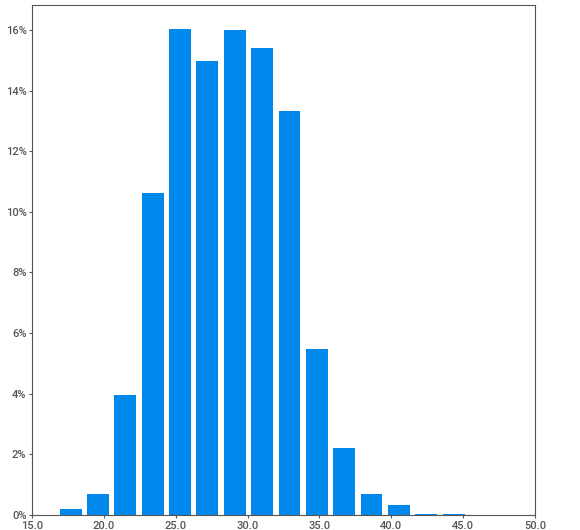
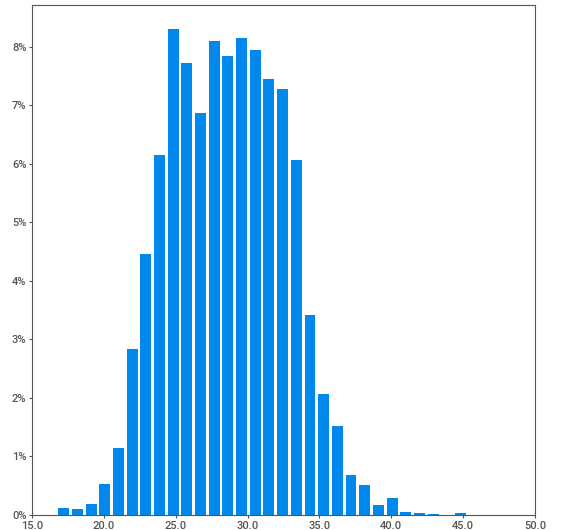
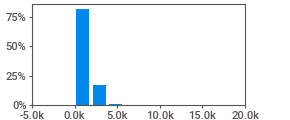
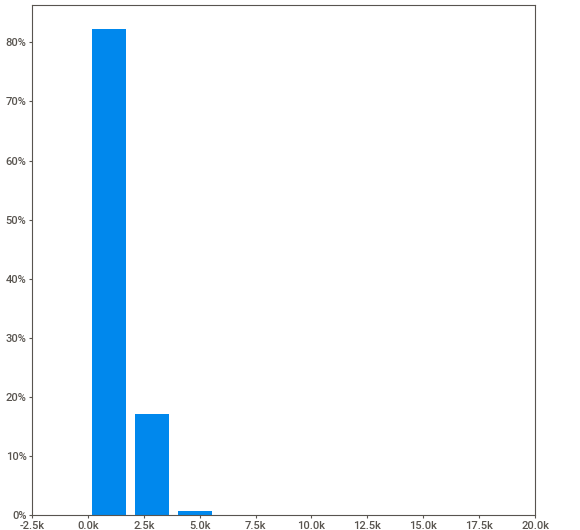
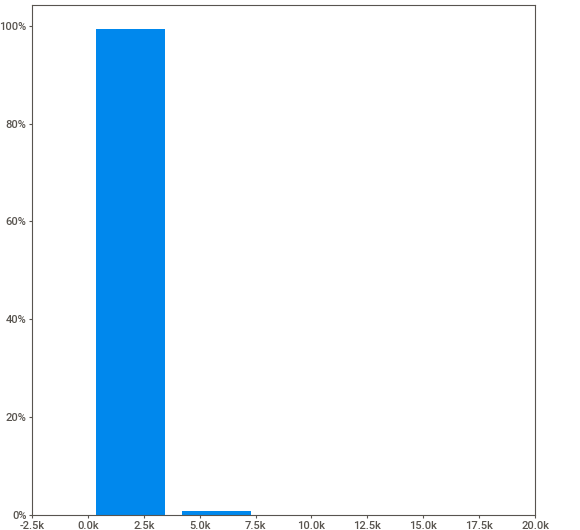
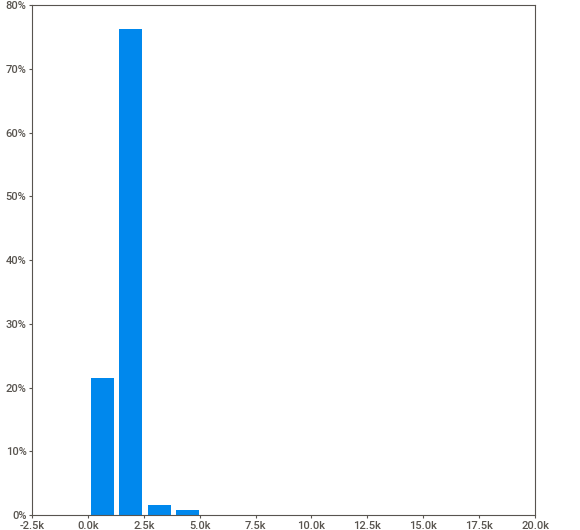
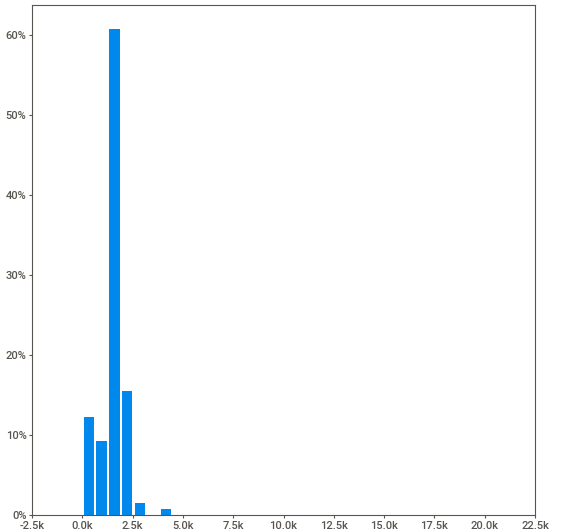
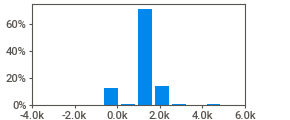
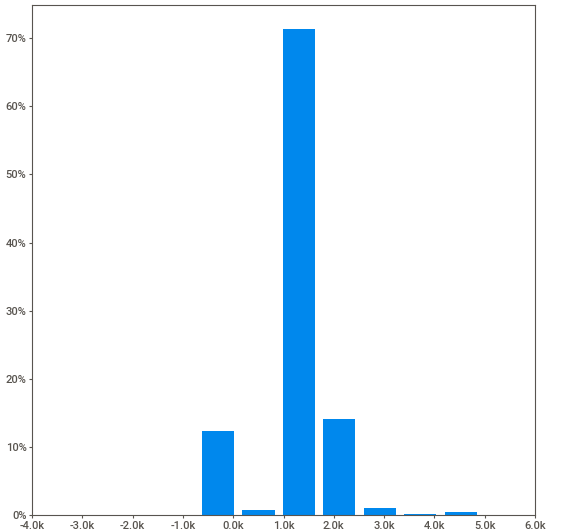
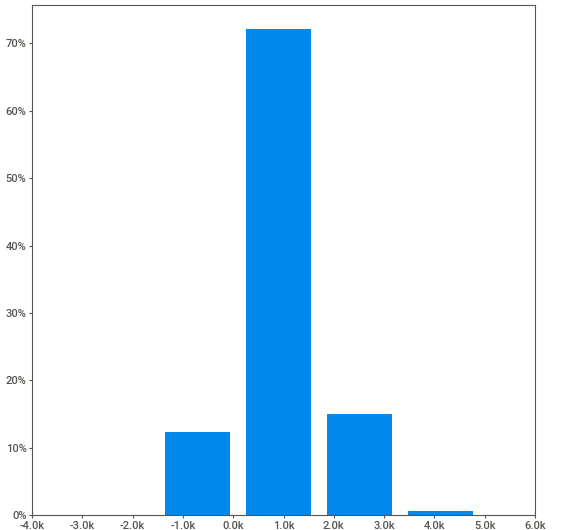
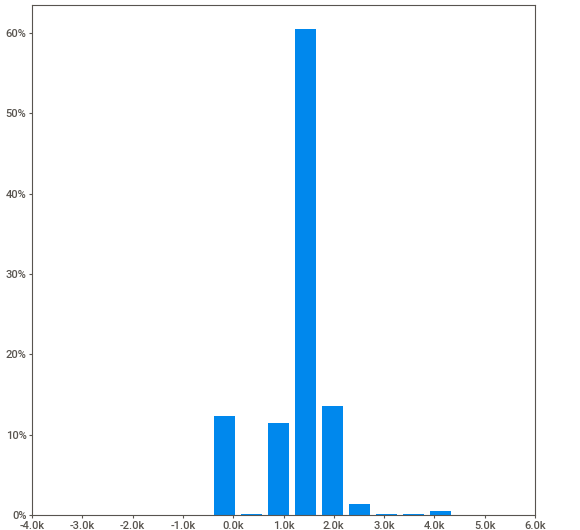
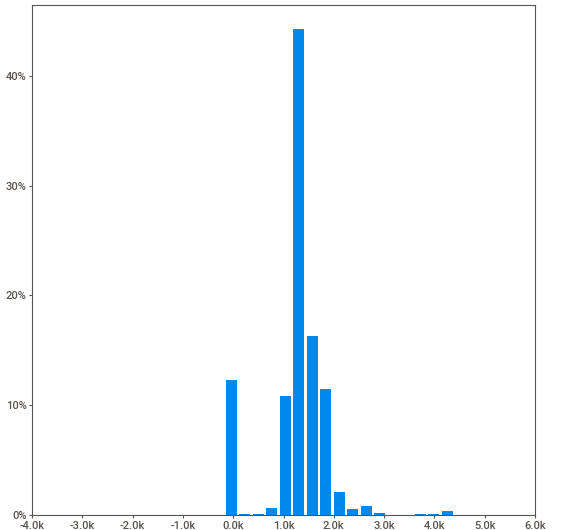
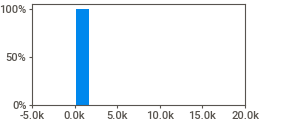
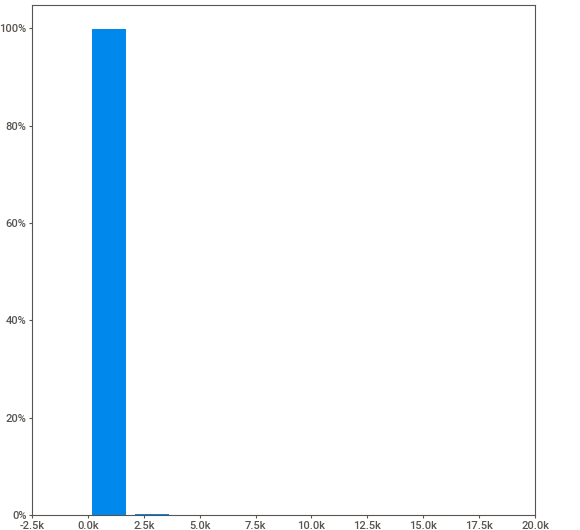
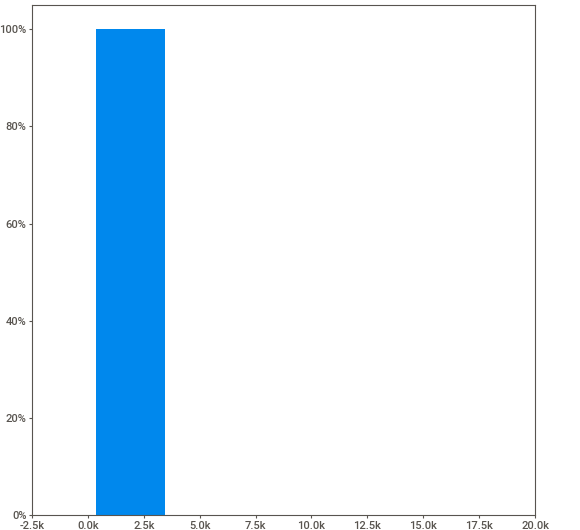
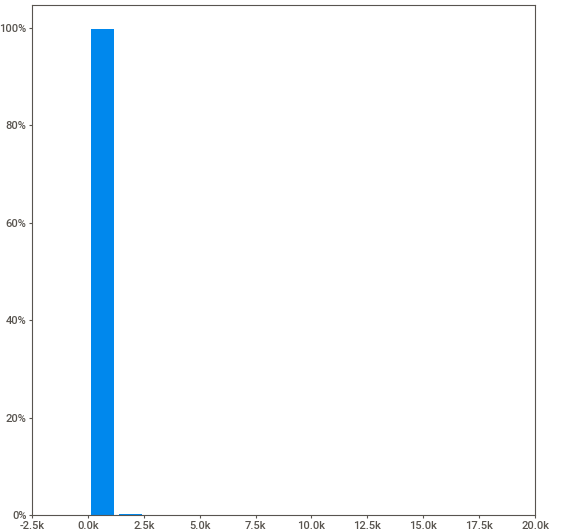
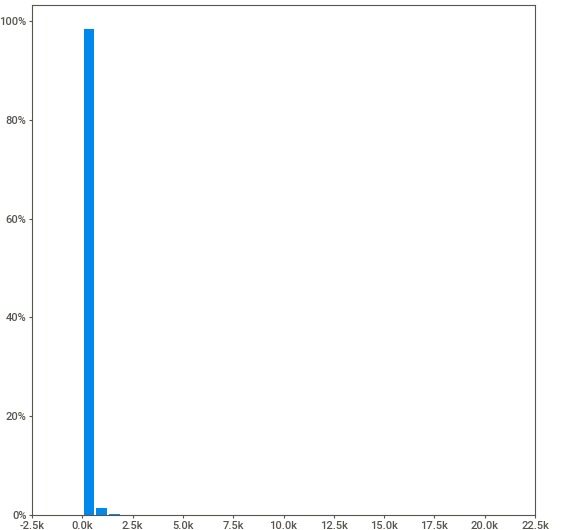
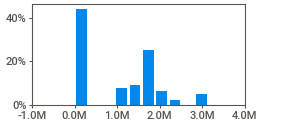
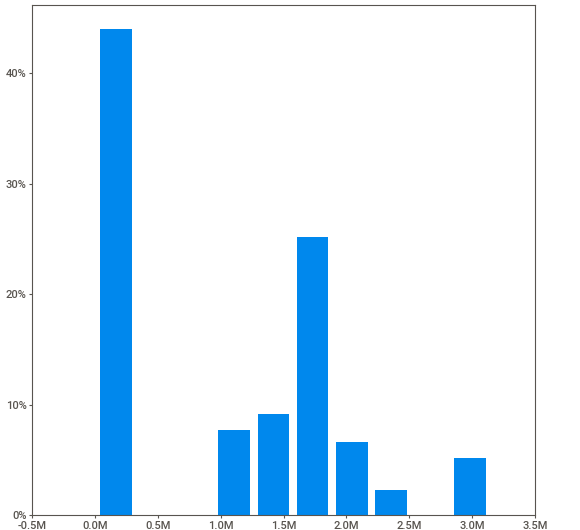
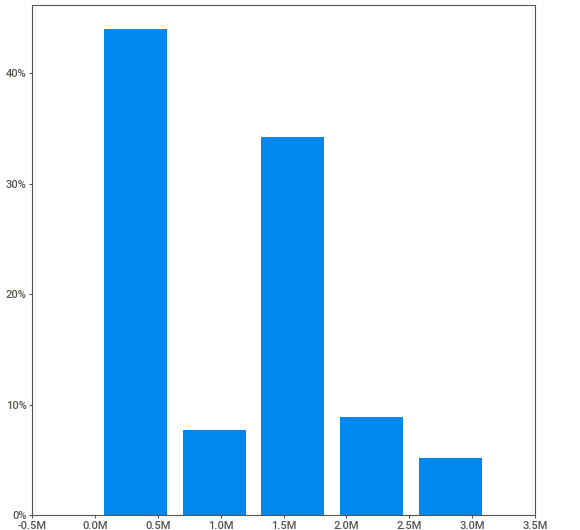
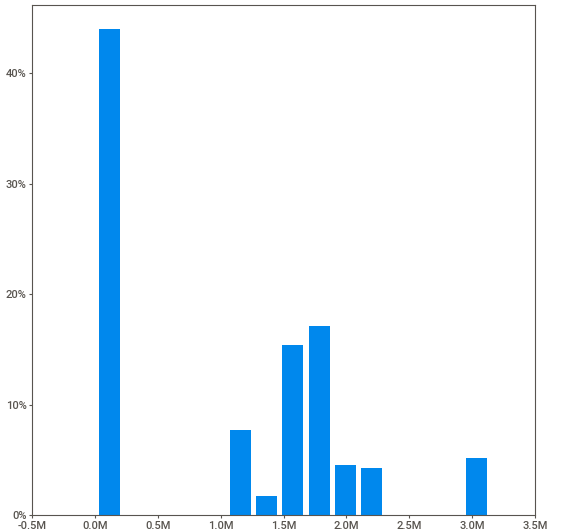
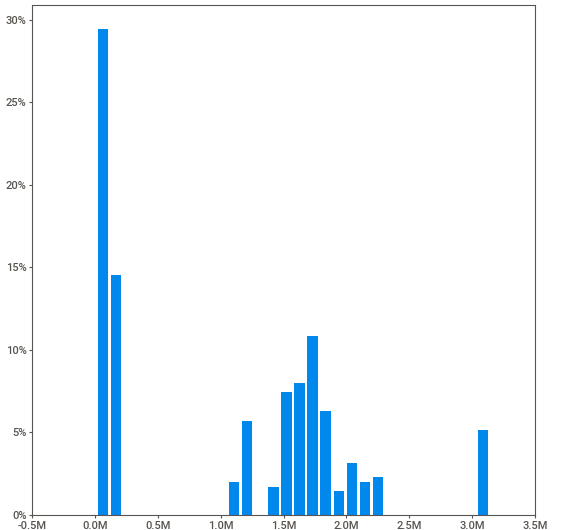
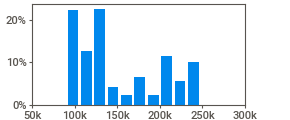
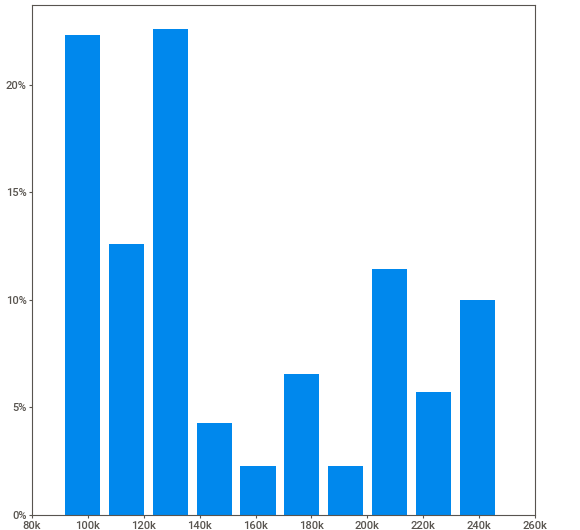
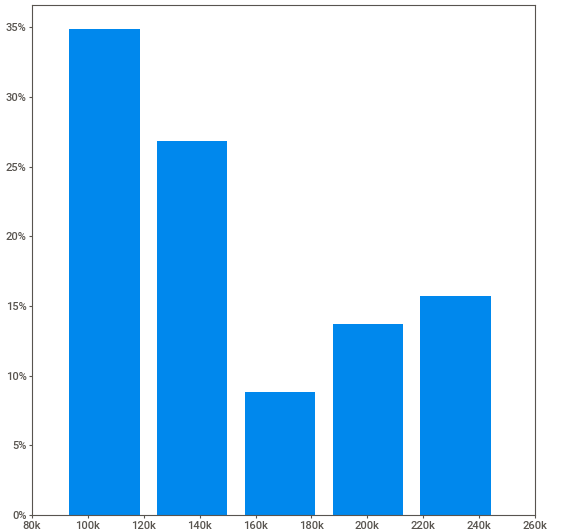
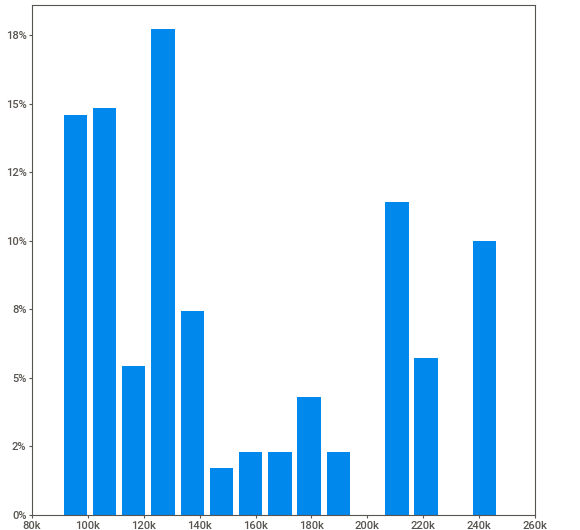
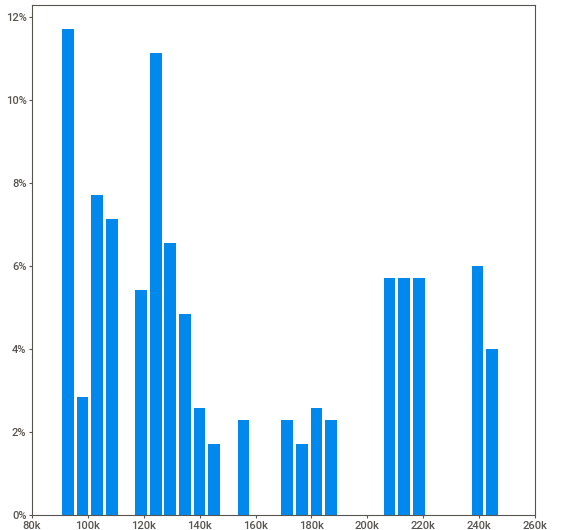
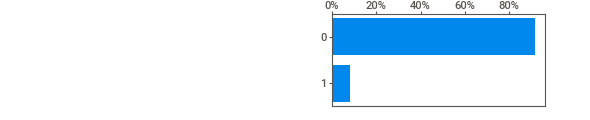
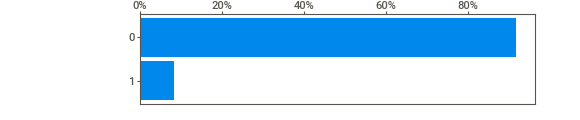
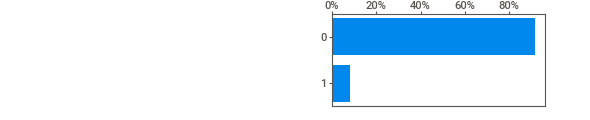
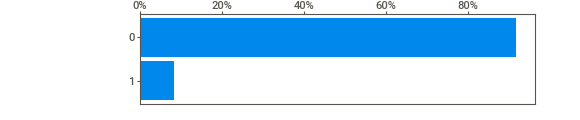
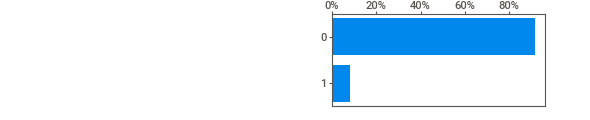
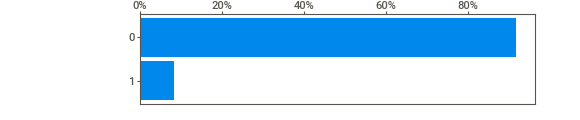
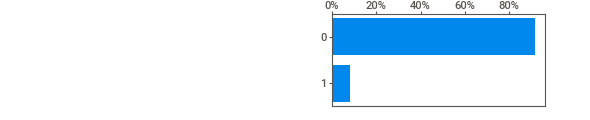
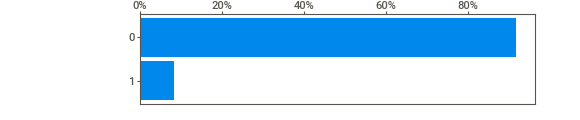
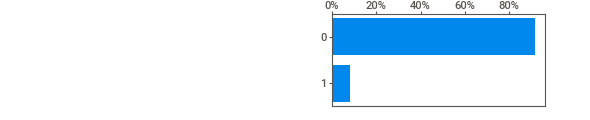
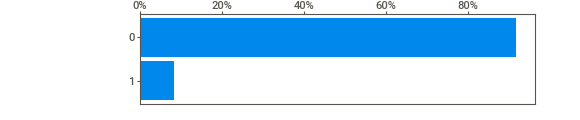
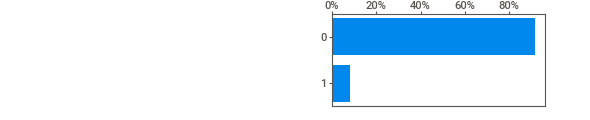
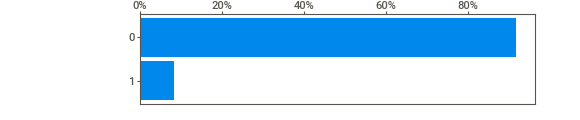
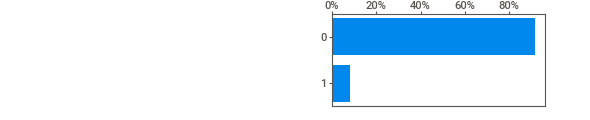
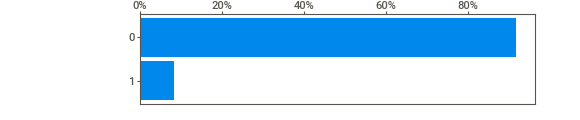
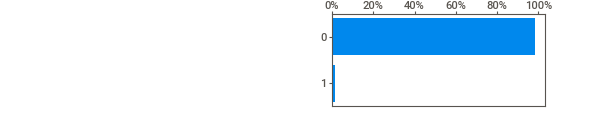
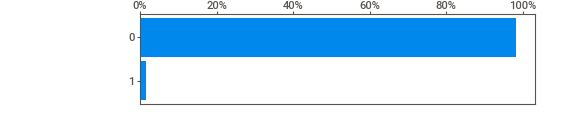
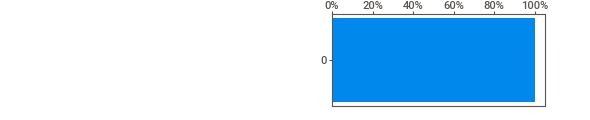
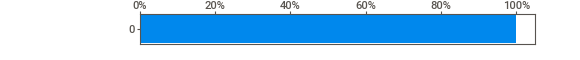
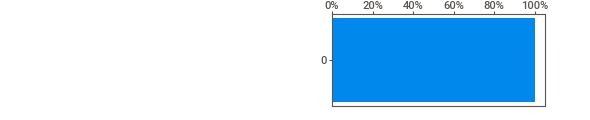
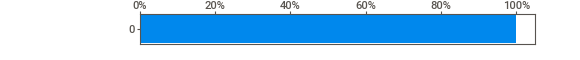
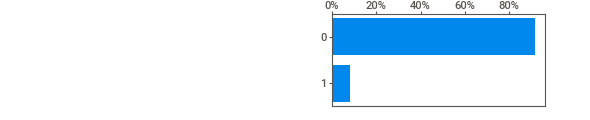
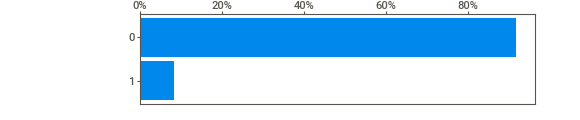
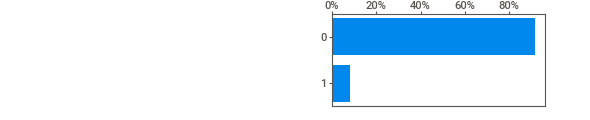
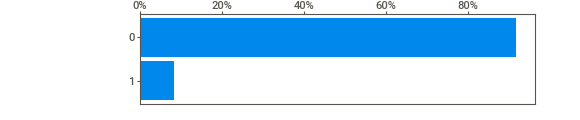
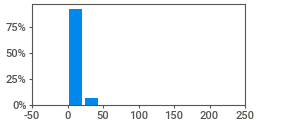
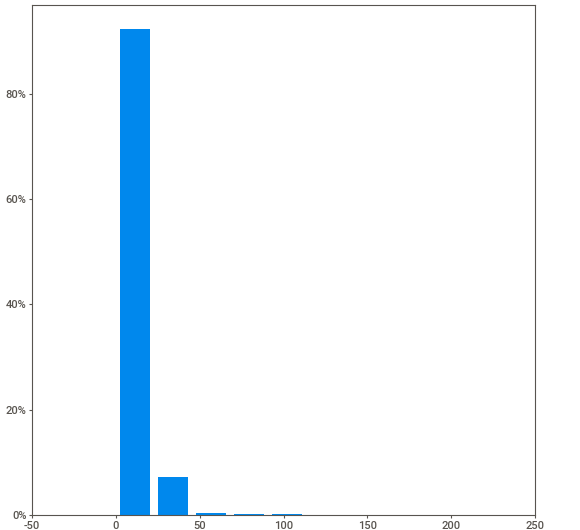
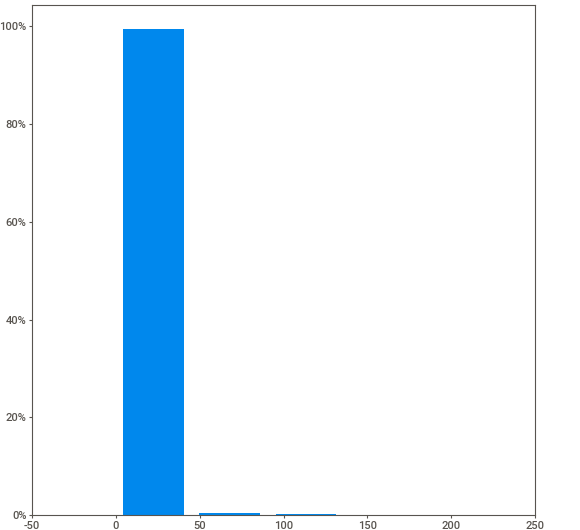
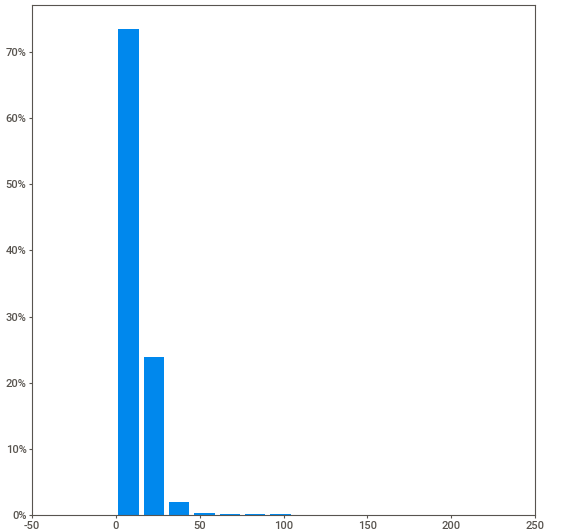
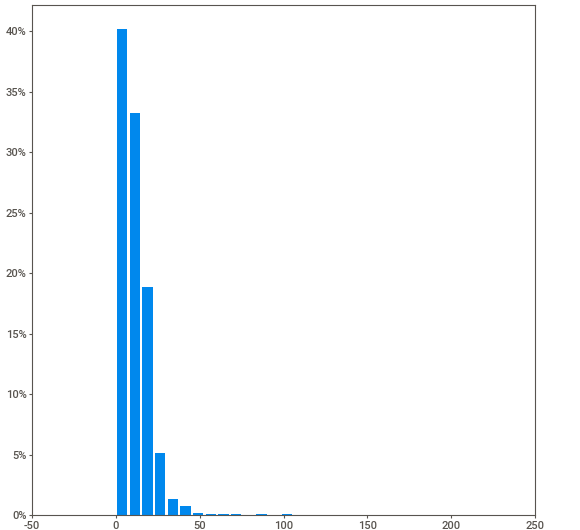
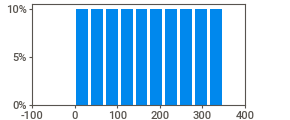
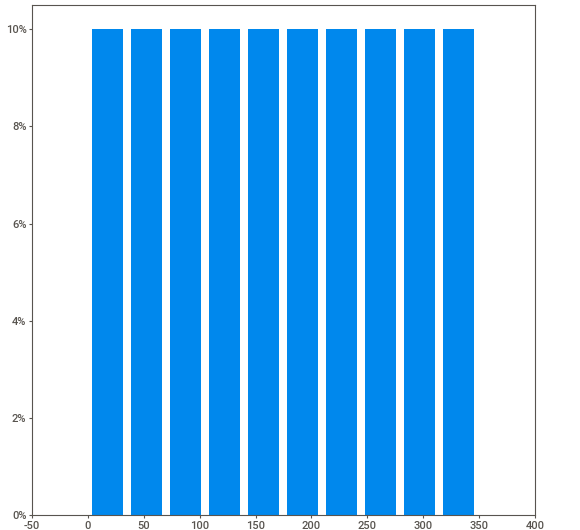
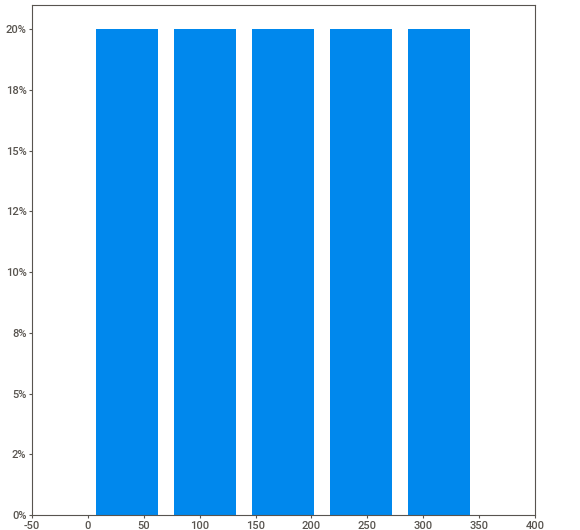
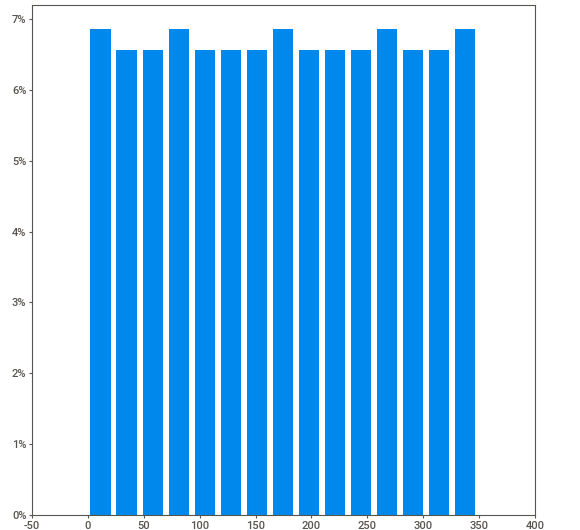
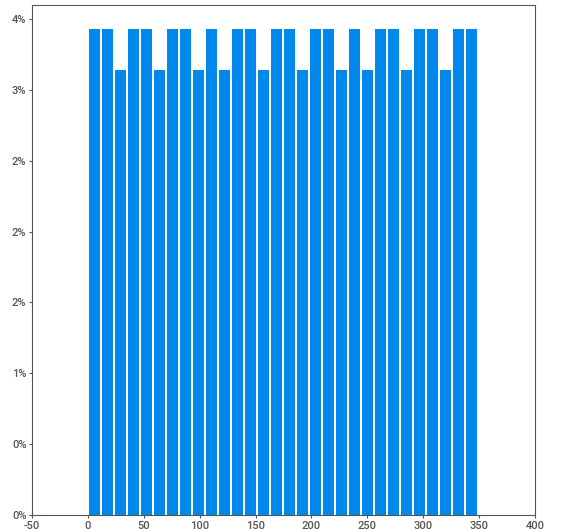
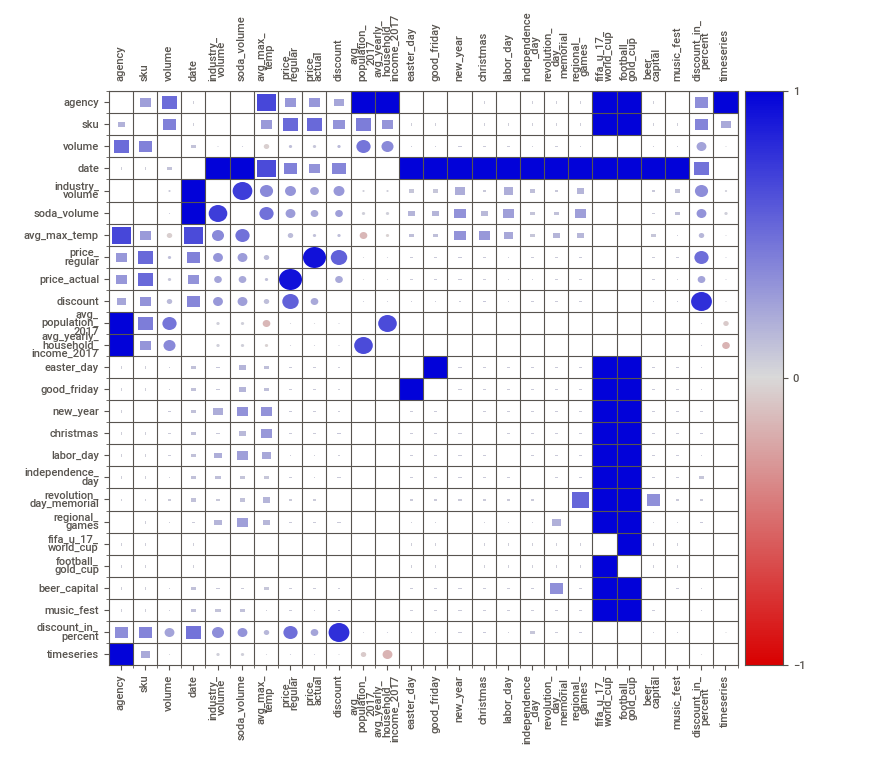
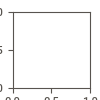

In [18]:
sweetviz.analyze(data).show_notebook();

In [22]:
# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

In [28]:
tmp = data[['date', 'time_idx']].drop_duplicates().sort_values(by=['date'], ascending=False)
display(tmp.head(5))
display(tmp.tail(5))

,date,time_idx
6885,2017-12-01,59
4901,2017-11-01,58
3387,2017-10-01,57
20767,2017-09-01,56
18901,2017-08-01,55


,date,time_idx
12368,2013-05-01,4
10732,2013-04-01,3
9011,2013-03-01,2
7233,2013-02-01,1
0,2013-01-01,0


In [29]:
# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

In [30]:
# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,53598,95032,-,-,new_year,-,-,-,-,-,-,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,28329,93614,-,-,new_year,-,-,-,-,-,-,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,32183,128574,-,-,-,-,-,independence_day,-,-,-,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,1729177,111048,-,-,-,-,-,-,-,-,-,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,147910,123013,-,-,-,-,-,-,-,-,-,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,3044268,182944,-,-,-,-,-,-,-,-,-,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,135561,100461,-,-,-,-,-,-,-,-,-,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,1739969,210213,easter_day,good_friday,-,-,-,-,-,-,-,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,1868030,175785,-,-,-,-,-,-,-,-,-,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,26635,130092,easter_day,good_friday,-,-,-,-,-,-,-,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


<a id='Preraringdataloaders'></a>
### Preraring dataloaders
[back to contents](#home)

In [31]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

In [35]:
training = TimeSeriesDataSet(
    data.loc[data['time_idx'] <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [41]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

In [42]:
# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=2)

<a id='Baselinemodel'></a>
### Baseline model
[back to contents](#home)

Evaluating a Baseline model that predicts the next 6 months by simply repeating the last observed volume gives us a simle benchmark that we want to outperform.

In [59]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
print(f"MAE (baseline):", round((actuals - baseline_predictions).abs().mean().item(), 3))

MAE (baseline): 293.009


<a id='TemporalFusionTransformer'></a>
### Temporal Fusion Transformer
[back to contents](#home)

<a id='Findoptimallearningrate'></a>
#### Find optimal learning rate
[back to contents](#home)

In [46]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/drive/MyDrive/colab_examples/.lr_find_3c7f6654-0da3-4fe7-80c4-876d5cd8412d.ckpt


suggested learning rate: 0.01862087136662867


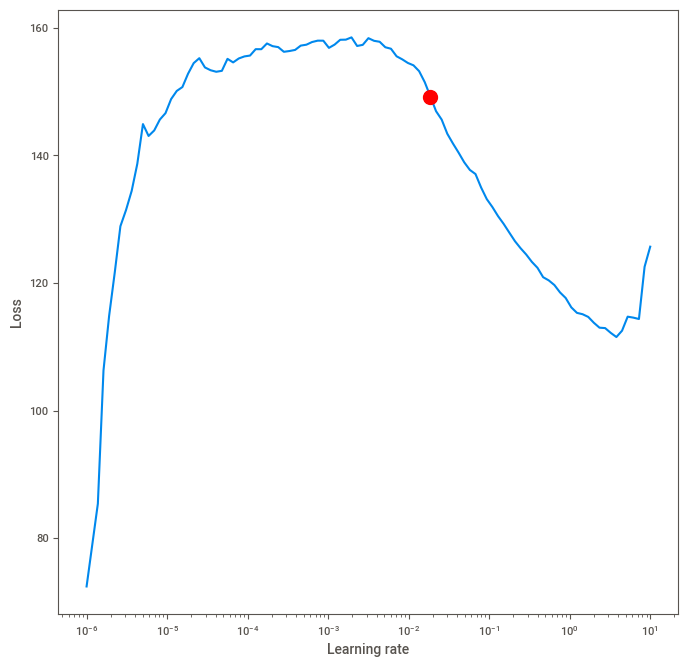

In [48]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

<a id='Modeltraining'></a>
#### Model training
[back to contents](#home)

If you have troubles training the model and get an error AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem', consider either uninstalling tensorflow or first execute

```python
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
```



In [53]:
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [54]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


In [55]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [103]:
print("TFT architecture:", end='\n'*2)
print(tft)

TFT architecture:

TemporalFusionTransformer(
  (loss): QuantileLoss()
  (logging_metrics): ModuleList(
    (0): SMAPE()
    (1): MAE()
    (2): RMSE()
    (3): MAPE()
  )
  (input_embeddings): MultiEmbedding(
    (embeddings): ModuleDict(
      (agency): Embedding(58, 16)
      (sku): Embedding(25, 10)
      (special_days): TimeDistributedEmbeddingBag(11, 6, mode=sum)
      (month): Embedding(12, 6)
    )
  )
  (prescalers): ModuleDict(
    (avg_population_2017): Linear(in_features=1, out_features=8, bias=True)
    (avg_yearly_household_income_2017): Linear(in_features=1, out_features=8, bias=True)
    (encoder_length): Linear(in_features=1, out_features=8, bias=True)
    (volume_center): Linear(in_features=1, out_features=8, bias=True)
    (volume_scale): Linear(in_features=1, out_features=8, bias=True)
    (time_idx): Linear(in_features=1, out_features=8, bias=True)
    (price_regular): Linear(in_features=1, out_features=8, bias=True)
    (discount_in_percent): Linear(in_features=1,

In [104]:
torch.save(
    tft.to('cpu').state_dict(), 
    '/content/drive/MyDrive/Trained models weights/temporal_fusion_transformer_stallion_data.pkl'
)

<a id='Evaluateperformance'></a>
#### Evaluate performance
[back to contents](#home)

In [118]:
tft_trained = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
tft_trained.load_state_dict(
    torch.load('/content/drive/MyDrive/Trained models weights/temporal_fusion_transformer_stallion_data.pkl')
)

<All keys matched successfully>

In [119]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft_trained.predict(val_dataloader)
print(f"MAE (TFT):", round((actuals - predictions).abs().mean().item(), 3))

MAE (TFT): 264.95


In [120]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = tft_trained.predict(val_dataloader, mode="raw", return_x=True)

In [121]:
x.keys()

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])

In [122]:
raw_predictions.keys()

('prediction',
 'encoder_attention',
 'decoder_attention',
 'static_variables',
 'encoder_variables',
 'decoder_variables',
 'decoder_lengths',
 'encoder_lengths')

In [125]:
??tft_trained.plot_prediction

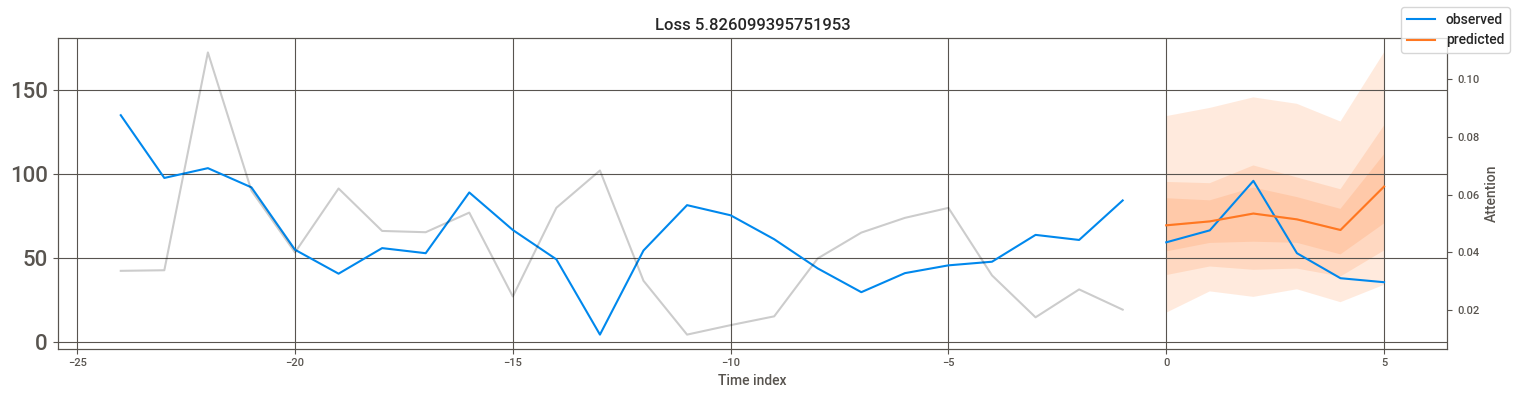

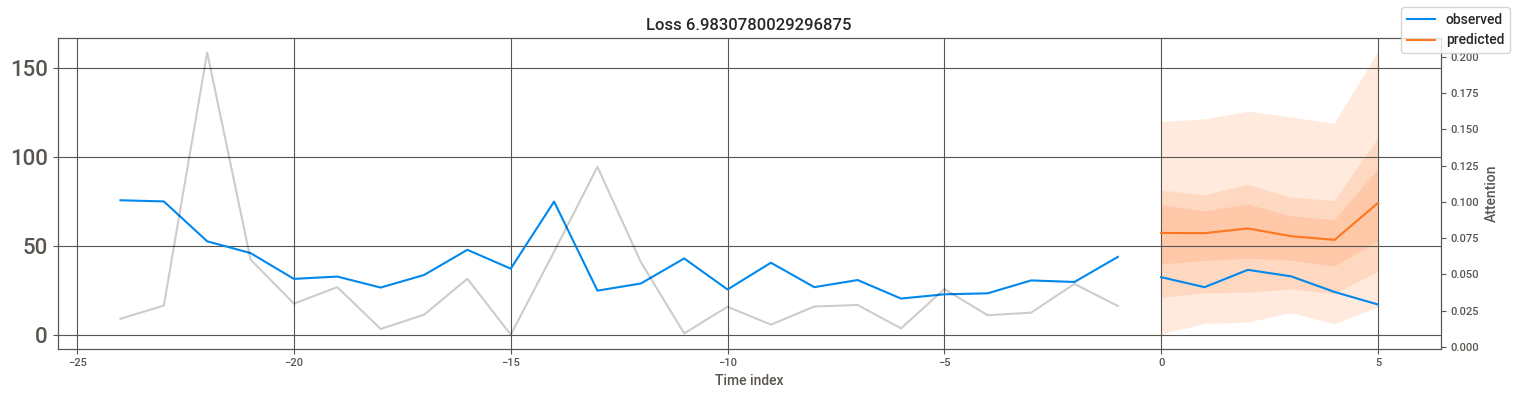

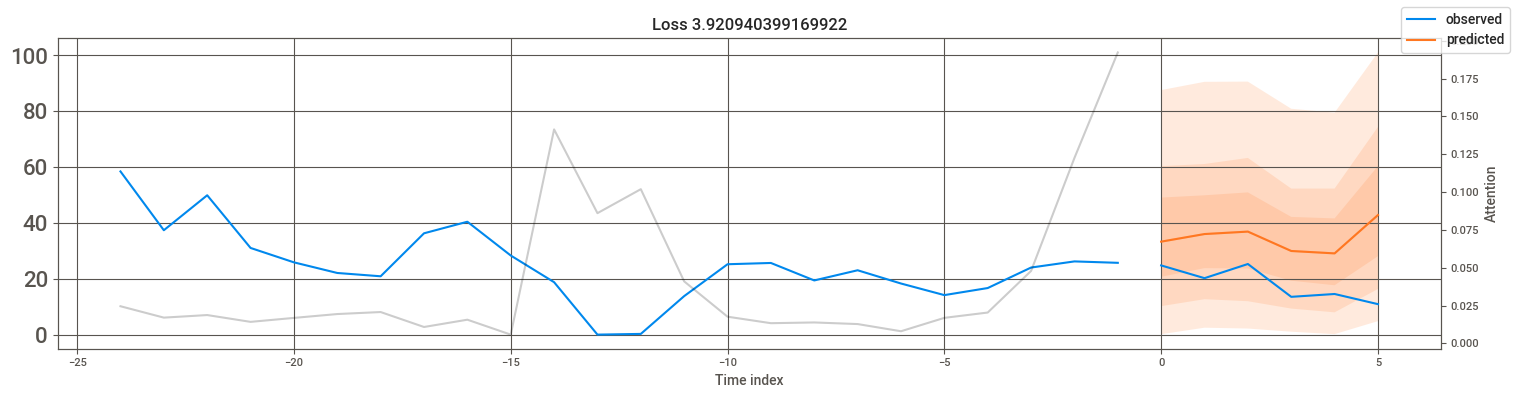

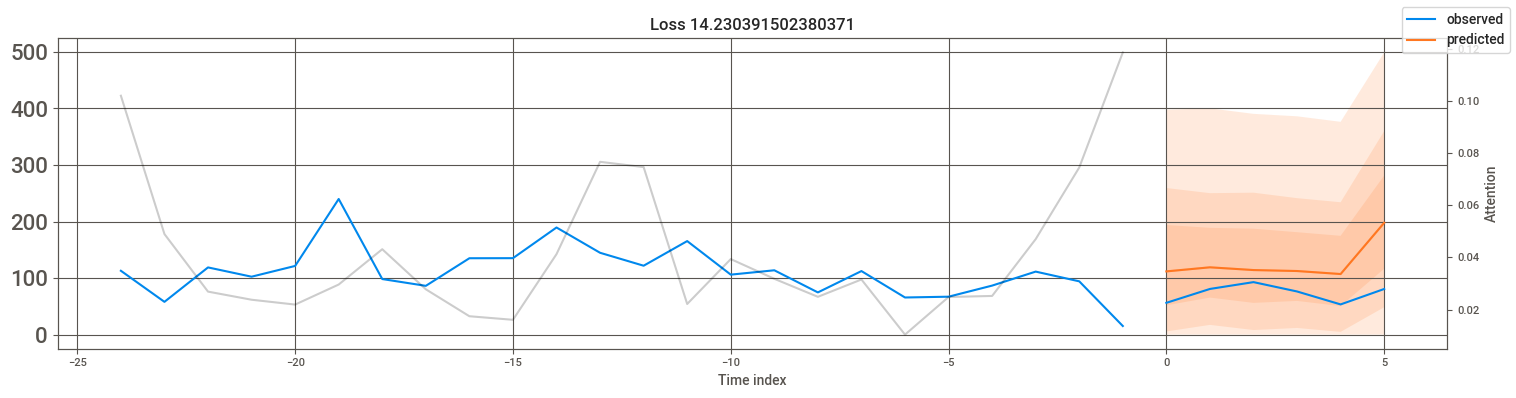

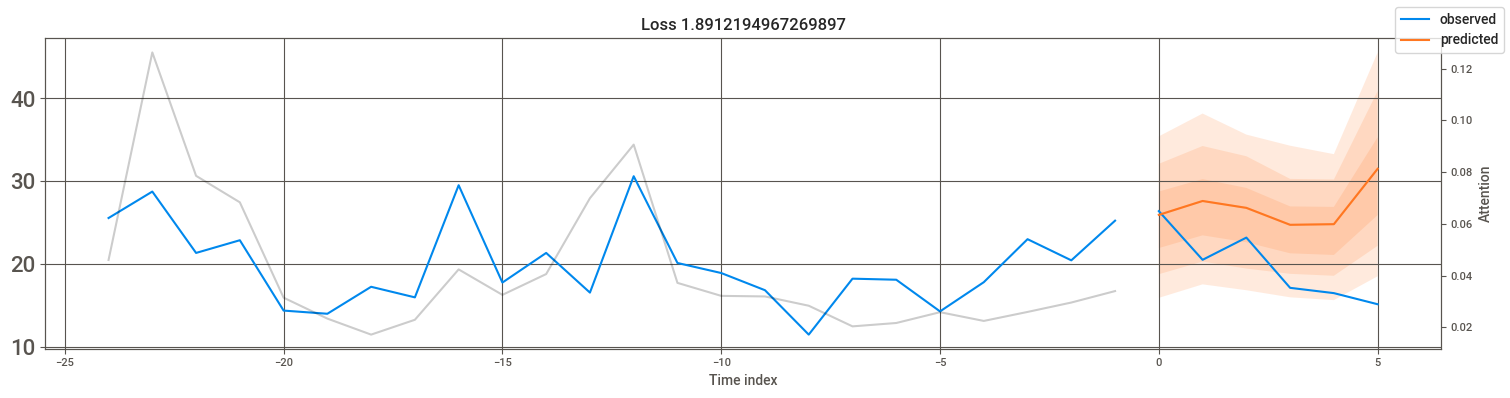

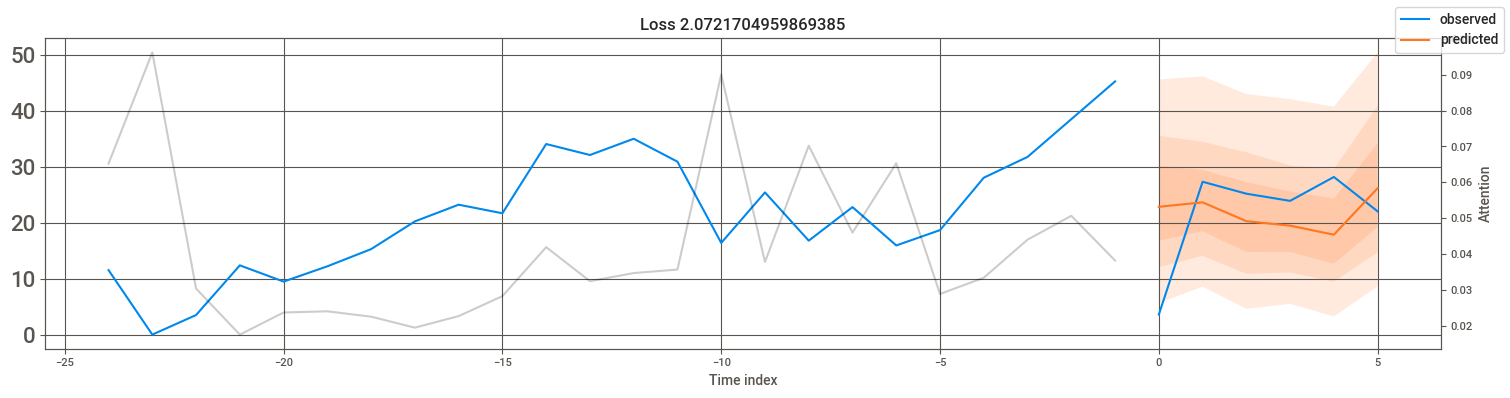

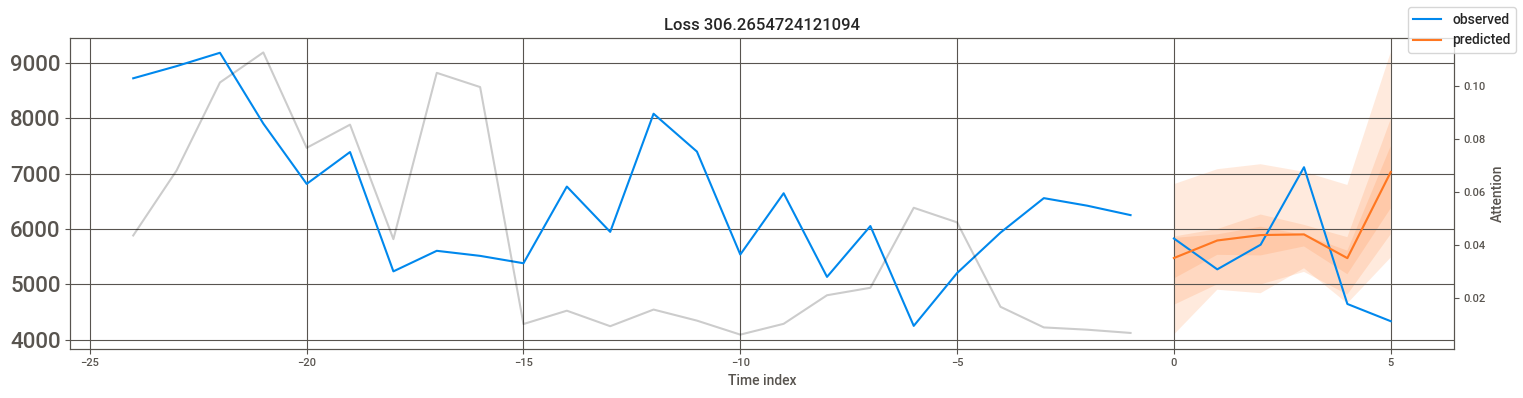

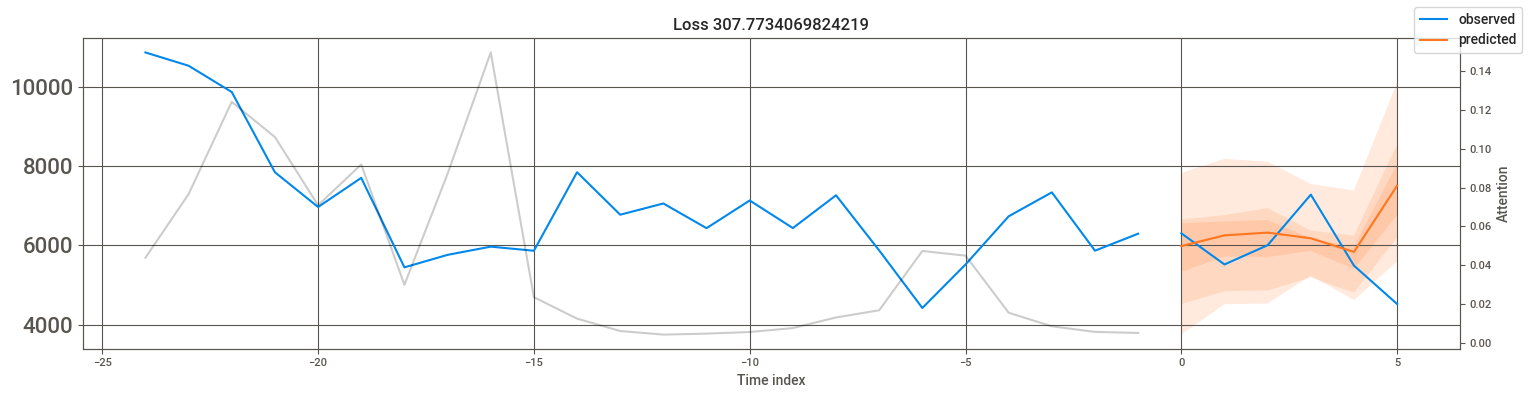

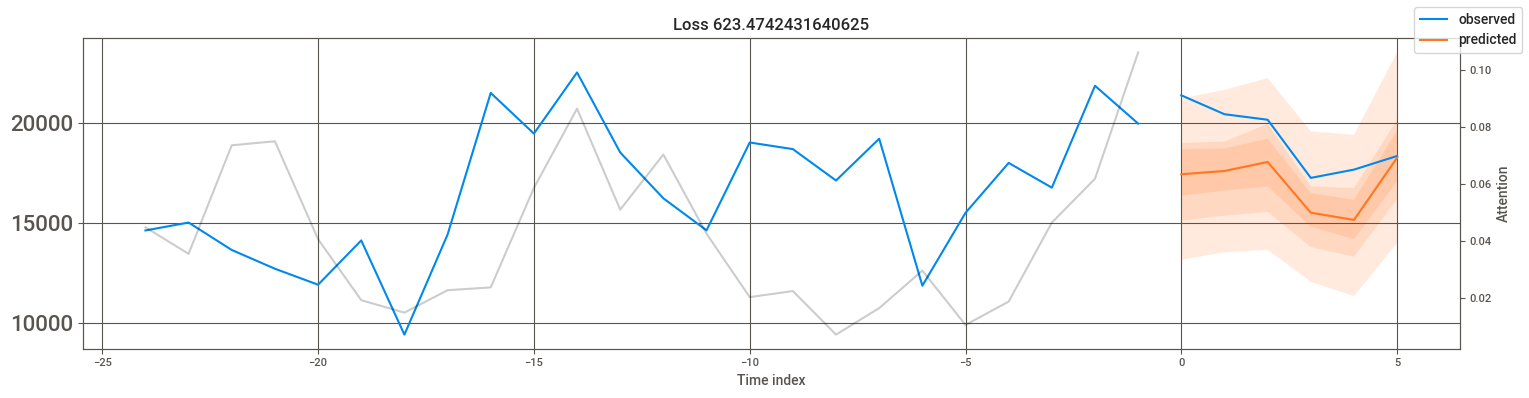

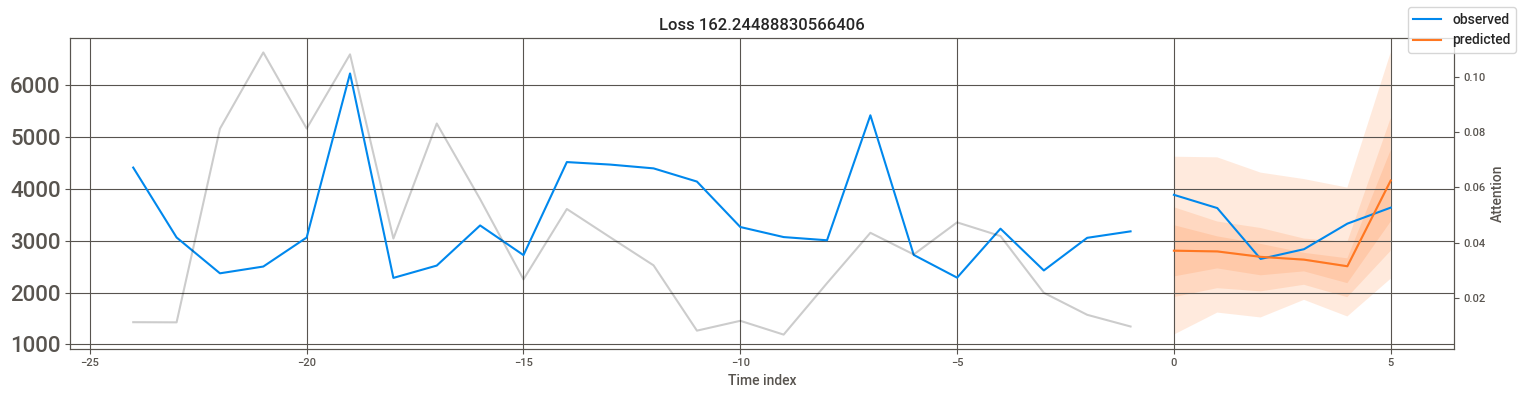

In [124]:
for idx in range(10):  # plot 10 examples
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.grid(axis='both')
    tft_trained.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True, ax=ax);
    ax.tick_params(axis='y', labelsize=16);